In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import r2_score

In [6]:
# Load the CSV data into a DataFrame and examine the first few rows to understand the structure
data_path = 'buyer-final.csv'
data = pd.read_csv(data_path, delimiter=';', usecols=['event_type', 'price', 'dateandtime'])
data.head()

,event_type,price,dateandtime
0,buy,80,2018.01.05 10:23
1,buy,8,2018.01.04 0:50
2,buy,8,2018.01.10 2:09
3,buy,8,2018.02.24 18:22
4,buy,8,2018.01.22 8:09


In [7]:
# Parse the 'dateandtime' column as datetime
data['dateandtime'] = pd.to_datetime(data['dateandtime'], format='%Y.%m.%d %H:%M')

# Filter out rows that are not 'buy' events
buy_events = data[data['event_type'] == 'buy']

# Create a new column with just the date (no time)
buy_events['date'] = buy_events['dateandtime'].dt.date

# Group by the date and sum up the prices to get daily revenue
daily_revenue = buy_events.groupby('date')['price'].sum().reset_index()

# We will treat each row as a separate day; to get weekly revenue, we can group by week number.
# First, let's add a column 'week_number' that extracts the week number from the date.
daily_revenue['week_number'] = pd.to_datetime(daily_revenue['date']).dt.isocalendar().week

# Now group by 'week_number' and sum the daily revenue to get weekly revenue
weekly_revenue = daily_revenue.groupby('week_number')['price'].sum().reset_index()

# Convert 'week_number' to a numeric value relative to the start date for regression analysis
start_week_number = weekly_revenue['week_number'].min()
weekly_revenue['week_number_relative'] = weekly_revenue['week_number'] - start_week_number

# We can now create a dictionary or DataFrame where the key/variable is the relative week number
# and the value is the weekly revenue amount.
weekly_revenue_dict = dict(zip(weekly_revenue['week_number_relative'], weekly_revenue['price']))

weekly_revenue_dict, daily_revenue.head()  # Display the dictionary and the first few rows of daily_revenue

({0: 2320,
  1: 4280,
  2: 7360,
  3: 5464,
  4: 10968,
  5: 12520,
  6: 13544,
  7: 19184,
  8: 25280,
  9: 23200,
  10: 21960,
  11: 28216,
  12: 20184},
          date  price  week_number
 0  2018-01-01    200            1
 1  2018-01-02    304            1
 2  2018-01-03    304            1
 3  2018-01-04    312            1
 4  2018-01-05    480            1)

In [8]:
# Reshape the data to fit the model
X = weekly_revenue['week_number_relative'].values.reshape(-1, 1)  # Independent variable
y = weekly_revenue['price'].values  # Dependent variable

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict values using the fitted model
y_pred = model.predict(X)

# Calculate R^2 value
r_squared = r2_score(y, y_pred)

# Prepare the results for plotting as well
results = pd.DataFrame({
    'Week_Number_Relative': weekly_revenue['week_number_relative'],
    'Actual_Revenue': y,
    'Predicted_Revenue': y_pred
})

r_squared, results.head()  # Display the R^2 value and the first few rows of results

(0.8625135183828526,
    Week_Number_Relative  Actual_Revenue  Predicted_Revenue
 0                     0            2320        2638.241758
 1                     1            4280        4691.868132
 2                     2            7360        6745.494505
 3                     3            5464        8799.120879
 4                     4           10968       10852.747253)

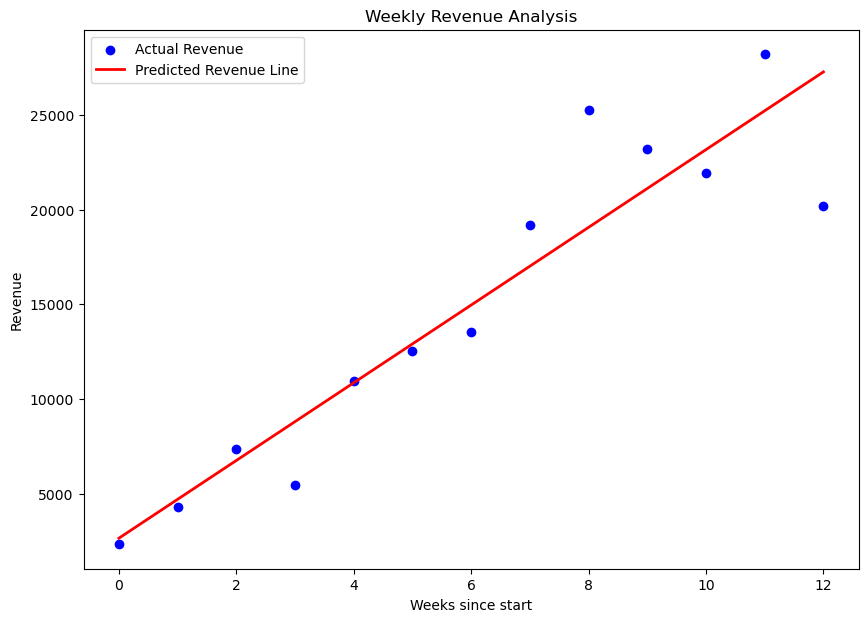

In [12]:
# Plotting the actual and predicted revenue
plt.figure(figsize=(10, 7))
plt.scatter(X, y, color='blue', label='Actual Revenue')
plt.plot(X, y_pred, color='red', linewidth=2, label='Predicted Revenue Line')
plt.title('Weekly Revenue Analysis')
plt.xlabel('Weeks since start')
plt.ylabel('Revenue')
plt.legend()
plt.show()

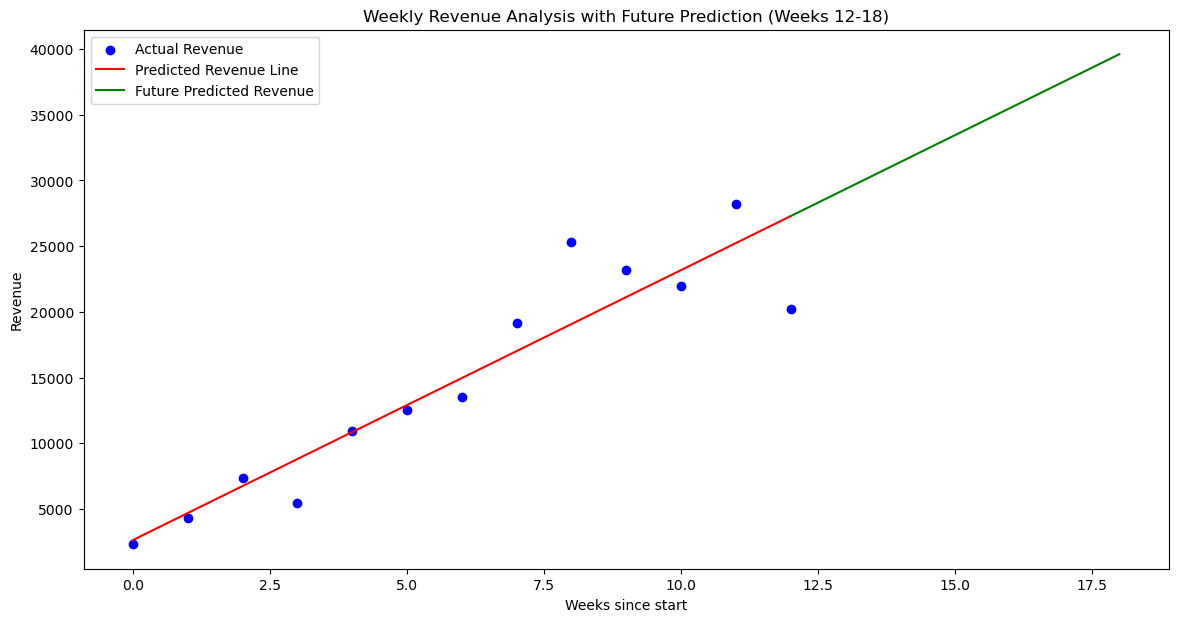

In [15]:
# Create an array for future weeks (12 to 18)
future_weeks = np.arange(12, 19).reshape(-1, 1)

# Predict future revenue using the fitted model
future_revenue_pred = model.predict(future_weeks)

# Create a DataFrame for future predictions for easy plotting
future_predictions = pd.DataFrame({
    'Week_Number_Relative': future_weeks.flatten(),
    'Predicted_Revenue': future_revenue_pred
})

# Plotting the actual, predicted and future predicted revenue
plt.figure(figsize=(14, 7))
plt.scatter(X, y, color='blue', label='Actual Revenue')
plt.plot(X, y_pred, color='red', label='Predicted Revenue Line')
plt.plot(future_weeks, future_revenue_pred, color='green', label='Future Predicted Revenue')
plt.title('Weekly Revenue Analysis with Future Prediction (Weeks 12-18)')
plt.xlabel('Weeks since start')
plt.ylabel('Revenue')
plt.legend()
plt.show()